# 	Приоритезация гипотез по увеличению выручки интернет-магазина, оценка результатов А/B-тестов

## Описание проекта

***
Вместе с отделом маркетинга мы подготовили список гипотез для увеличения выручки.

В нашем распоряжении имеются данные:
- 9 гипотез, которые хранятся в файле `hypothesis.csv`;
- результаты о проведенном А/В-тесте, которые хранятся в файлах `orders.csv` и `visitors.csv`.
***
**Целью нашей работы**

По имеющимся данным выполнить приоритезацию гипотез, выполнить запуск A/B-тест, по завершению которого сформировать результаты и выполнить пошаговый анализ данного теста.
***
**Структура проекта**
- Часть 1. Приоритезация гипотез.

  Для выполнения приортезация гипотезы, я предлагаю выполнить следующие действия:
  - Применить фреймворк ICE для приоритизации гипотез.
  - Применить фреймворк RICE для приоритизации гипотез.
  - По результатам указать, как изменилась приоритизация гипотез при применении RICE вместо ICE, и объясните, почему так произошло.

- Часть 2. А/В - тестирование.

  Анализ тестирования. По результатам A/B-теста предлагается выполнить пошаговый анализ, итогом которого будет решение с объяснением одного из вариантов:
  - Остановить тест, зафиксировать победу одной из групп.
  - Остановить тест, зафиксировать отсутствие различий между группами.
  - Продолжить тест.
***
**Описание данных**

- Для выполнения приоритезации гипотез в нашем распоряжении имеется датасет `hypothesis.csv`. Структура датасета:
    - `Hypothesis` — краткое описание гипотез;
    - `Reach` — охват пользователей по 10-балльной шкале;
    - `Impact` — влияние на пользователей по 10-балльной шкале;
    - `Confidence` — уверенность в гипотезе по 10-балльной шкале;
    - `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.
- По результатам A/B-теста у нас имеются результаты, которые описаны в файлах `orders.csv` и `visitors.csv`.
  - Структуру `orders.csv`:
    - transactionId — идентификатор заказа;
    - visitorId — идентификатор пользователя, совершившего заказ;
    - date — дата, когда был совершён заказ;
    - revenue — выручка заказа;
    - group — группа A/B-теста, в которую попал заказ.
  - Структуру `visitors.csv`:
    - date — дата;
    - group — группа A/B-теста;
    - visitors — количество пользователей в указанную дату в указанной группе A/B-теста.

In [1]:
#выполним загрузку необходимых библиотек для выполнения работы
import pandas as pd
import datetime as dt
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from google.colab import drive
drive.mount('/content/drive')

#увеличем максимальное количество, отображающихся колонок
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

#увеличим шириниу колонок
pd.set_option('display.max_colwidth', 0)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Часть 1. Приоритезация гипотез.

### Загрузка данных и подготовка их к анализу

Выполним загрузка таблицы `hypothesis.csv` и выполним предобработку данных для последующей работы

In [2]:
# назначаем переменные для исходных данных по гипотезам
try:
    hypothesis = pd.read_csv('/datasets/hypothesis.csv')
except:
    hypothesis = pd.read_csv('/content/drive/MyDrive/datasets_YaP/hypothesis.csv')

In [3]:
# выведим таблицу гипотез
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [4]:
# изучим информацию по таблице
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


В инорфмации полученной имеются проблемы, которые необходимы устранить для более комфортной работы:
- некорректное наименование колонок (необходимо привести к питонообразному виду).

In [5]:
# приводим наименование колонок к нижнем регистру
hypothesis.columns = map(str.lower, hypothesis.columns)

In [6]:
# выведим таблицу гипотез с обновленным наименование колонок
hypothesis

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


Таблица готова к работе, переходим к приоритезации гипотез.

### Приоритезация гипотез

***
Перед выполнением применения фреймфорков `ICE` и `RICE`, необходимо понять в чем разница. Одним из ключевых факторов явлется, что по фреймфорку `RICE` мы учитываем параметр `reach`, который нам дает более конкретное понимание какое количество пользователей охватит та или иная предполагаемай доработка, то есть какое количество пользователей охватим за заданный период.
***

#### Применение фреймфорк `ICE`

In [7]:
# выполним расчет ICE для гипотез и добавим значения в новую колонку таблицы 'hypothesis'
hypothesis['ICE'] = round((hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts'], 2)

In [8]:
# выведим столбцы 'hypothesis' и 'ICE', отсортированную по убыванию приоритета
hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


**Итог:** По фреймворк `ICE` приортетными гипотезами являются - <b> 8, 0, 7 </b>.

#### Применение фреймфорк `RICE`

In [9]:
# выполним расчет RICE для гипотез и добавим значения в новую колонку таблицы 'hypothesis'
hypothesis['RICE'] = (hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']

In [10]:
# выведим столбцы 'hypothesis' и 'RICE', отсортированную по убыванию приоритета
hypothesis[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


**Итог:** По фреймворк `RICE` картина поменялась, наиболее приоритетным гипотезами являются - <b> 7, 2, 0 </b>.
На первом месте находится гипотеза 7, так как ее показатели Reach в общем датасете имеют наибольшее значение - **10**, то есть по данной гипотезе затронется наибольшее количество пользователей, что нельзя сказать про гипотезу **8**(значение параметра 'reach' равно **1**), которая по фреймворк `ICE` находилась на первом месте. Для наглядности вывода выведем гипотезу с колонками `'reach'` и `'RICE'`.

In [11]:
# отсортируем датасет
hypothesis[['hypothesis', 'RICE', 'reach']].sort_values(by='RICE', ascending=False)

,hypothesis,RICE,reach
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0,8
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0,5
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2,1
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0,8
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0,2
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0,3
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0,3


**Вывод:** По полученным данным фреймворков и промежуточным выводом наиболее приоритезированная гипотезами для последующей работ по тестированию предлагаю брать гипотезы **7** и также можно рассмотреть гипотезу **0**.

## Часть 2. А/В - тестирование

***
Нам необходимо проанализировать A/B-тест:
- Построим график кумулятивной выручки по группам.
- Построим график кумулятивного среднего чека по группам.
- Построим график относительного изменения кумулятивного среднего чека группы B к группе A.
- Построим график кумулятивного среднего количества заказов на посетителя по группам.
- Построим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A.
- Построим точечный график количества заказов по пользователям.
- Посчитаем 95-й и 99-й перцентили количества заказов на пользователя. Выберем границу для определения аномальных пользователей.
- Построим точечный график стоимостей заказов.
- Посчитаем 95-й и 99-й перцентили стоимости заказов. Выберем границу для определения аномальных заказов.
- Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным.
- Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным.
- Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным.
- Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным.
***
Перед выполнением A/B-теста необходимо выполнить предобработку данных, которые мы получили в таблицах `orders.csv` и `visitors.csv`.

### Загрузка данных и подготовка их к анализу

In [12]:
# назначаем переменную для исходных данных по заказам
try:
    orders = pd.read_csv('/datasets/orders.csv')
except:
    orders = pd.read_csv('/content/drive/MyDrive/datasets_YaP/orders.csv')

In [13]:
# назначаем переменную для исходных данных по пользователям
try:
    visitors = pd.read_csv('/datasets/visitors.csv')
except:
    visitors = pd.read_csv('/content/drive/MyDrive/datasets_YaP/visitors.csv')

#### Обработка таблицы заказов

In [14]:
# выведим таблицу заказов
orders

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A


In [15]:
# изучим информацию по таблице
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


В инорфмации полученной имеются проблемы, которые необходимы устранить:
- некорректное наименование колонок (необходимо привести к питонообразному виду);
- колонка 'date' имеет неправильный тип данных (необходимо привести к типу datetime).

In [16]:
# приведем к правильному виду наименование колонок
orders.columns = ['transaction_id', 'visitor_id', 'date', 'revenue', 'group']

In [17]:
# выполняем проверку корректности наименования колонок
orders.columns

Index(['transaction_id', 'visitor_id', 'date', 'revenue', 'group'], dtype='object')

In [18]:
# приведем колонку 'date' к типу datetime
orders['date'] = pd.to_datetime(orders['date'])

In [19]:
# выведим информацию по таблице и проверим выполненные преобразования
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1197 non-null   int64         
 1   visitor_id      1197 non-null   int64         
 2   date            1197 non-null   datetime64[ns]
 3   revenue         1197 non-null   int64         
 4   group           1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


In [20]:
# выведим таблицу
orders.head(10)

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
6,398296753,2900797465,2019-08-15,1860,B
7,2626614568,78758296,2019-08-15,1044,A
8,1576988021,295230930,2019-08-15,13710,A
9,1506739906,1882260405,2019-08-15,1855,B


In [21]:
# выполним проверку на наличие дубликатов
if orders.duplicated().sum() == 0:
    print('Дубликаты отсутствуют')
else:
    print('В таблице имеются дубликаты')

Дубликаты отсутствуют


In [22]:
# посчитаем количество пропусков по каждой колонке таблицы
orders.isna().sum()

transaction_id    0
visitor_id        0
date              0
revenue           0
group             0
dtype: int64

В представленной таблице пропуски отсутствуют.

In [23]:
# выведим период теста предоставленный в таблице
print("Минимальная дата:", orders['date'].min())
print("Максимальная дата:", orders['date'].max())

Минимальная дата: 2019-08-01 00:00:00
Максимальная дата: 2019-08-31 00:00:00


<b>Итог:</b>
В таблице orders были выполнены следующие действия:
- приведены наименования колонок к питонообразному виду;
- колонка 'date' приведена к типу datetime;
- дубликаты и пропуски в колонке отсутствуют.

Таблица `orders` готова к работе. Период теста в предоставленный период с 1 августа 2019 по 30 августа 2019.

#### Обработка таблицы пользователей

In [24]:
# выведим таблицу пользователей
visitors

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


In [25]:
# изучим информацию по таблице
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


В инорфмации полученной имеются проблемы, которые необходимы устранить:
- колонка 'date' имеет неправильный тип данных (необходимо привести к типу datetime).

In [26]:
# приведем колонку 'date' к типу datetime
visitors['date'] = pd.to_datetime(visitors['date'])

In [27]:
# выведим информацию по таблице и проверим выполненные преобразования
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


In [28]:
# выполним проверку на наличие дубликатов
if visitors.duplicated().sum() == 0:
    print('Дубликаты отсутствуют')
else:
    print('В таблице имеются дубликаты')

Дубликаты отсутствуют


In [29]:
# посчитаем количество пропусков по каждой колонке таблицы
visitors.isna().sum()

date        0
group       0
visitors    0
dtype: int64

В представленной таблице пропуски отсутствуют.

In [30]:
# выведим период теста предоставленный в таблице
print("Минимальная дата:", visitors['date'].min())
print("Максимальная дата:", visitors['date'].max())

Минимальная дата: 2019-08-01 00:00:00
Максимальная дата: 2019-08-31 00:00:00


In [31]:
# проверим количество групп
visitors['group'].value_counts()

A    31
B    31
Name: group, dtype: int64

Необходимо выполнить проверку имеются ли пользователи, которые находятся в двух группах одновременно.

In [32]:
# определим переменные по группам
group_a = orders[orders['group'] == 'A']['visitor_id']
group_b = orders[orders['group'] == 'B']['visitor_id']

In [33]:
# cформируем таблицу с двумя группами по visitor_id
orders_groups_ab = orders.query('visitor_id in @group_a and visitor_id in @group_b')

In [34]:
# выведим всех уникальных пользователей
orders_groups_ab['visitor_id'].unique()

array([4069496402,  963407295,  351125977, 3234906277,  199603092,
        237748145, 3803269165, 2038680547, 2378935119, 4256040402,
       2712142231,    8300375,  276558944,  457167155, 3062433592,
       1738359350, 2458001652, 2716752286, 3891541246, 1648269707,
       3656415546, 2686716486, 2954449915, 2927087541, 2579882178,
       3957174400, 2780786433, 3984495233,  818047933, 1668030113,
       3717692402, 2044997962, 1959144690, 1294878855, 1404934699,
       2587333274, 3202540741, 1333886533, 2600415354, 3951559397,
        393266494, 3972127743, 4120364173, 4266935830, 1230306981,
       1614305549,  477780734, 1602967004, 1801183820, 4186807279,
       3766097110, 3941795274,  471551937, 1316129916,  232979603,
       2654030115, 3963646447, 2949041841])

In [35]:
print('Кол-во пользоватлей в группе А и В:', orders_groups_ab['visitor_id'].nunique())
print('Всего пользователей:', orders['visitor_id'].nunique())
print('Процент пользователей групп от общего числа:', round(orders_groups_ab['visitor_id'].nunique() / orders['visitor_id'].nunique() * 100, 1), '%')

Кол-во пользоватлей в группе А и В: 58
Всего пользователей: 1031
Процент пользователей групп от общего числа: 5.6 %


In [36]:
# посчитаем сколько заказов выполнили пользователи, находящиеся в двух группах одновременно
orders_groups_ab['revenue'].count()

181

В двух группах одновременно присутствуют 58 пользователей, которые выполнили 181 заказ.
Общее колоичество пользователей равно 1031, по полученным расчетам мы видим, что пользователи находящиеся в двух группах одновременно составляют 5,6% от общего количества.

По представленному проценту предлагается данные позиции удалить из датасета, так как их удаление не повлечет сильных изменений на последующий анализ

In [37]:
# удалим пользователей, находящиеся в двух группах
orders = orders[~orders['visitor_id'].isin(orders_groups_ab['visitor_id'])]

In [38]:
# проверим оставшееся количество пользователей
orders['visitor_id'].nunique()

973

<b>Итог:</b>
В таблице visitors были выполнены следующие действия:
- колонка 'date' приведена к типу datetime;
- дубликаты и пропуски в колонке отсутствуют.

Таблица `visitors` готова к работе. Период теста в предоставленный период с 1 августа 2019 по 30 августа 2019 -> совпадает с периодом таблицы `orders`.

### Проверка пользователей, находящихся в нескольких группах одновременно

In [39]:
# проверим количество групп
visitors['group'].value_counts()

A    31
B    31
Name: group, dtype: int64

Необходимо выполнить проверку имеются ли пользователи, которые находятся в нескольких группах одновременно.

In [40]:
# определим переменные по группам
group_a = orders[orders['group'] == 'A']['visitor_id']
group_b = orders[orders['group'] == 'B']['visitor_id']

In [41]:
# cформируем таблицу с двумя группами по visitor_id
orders_groups_ab = orders.query('visitor_id in @group_a and visitor_id in @group_b')

In [42]:
# выведим всех уникальных пользователей
orders_groups_ab['visitor_id'].unique()

array([], dtype=int64)

In [43]:
print('Кол-во пользоватлей в группе А и В:', orders_groups_ab['visitor_id'].nunique())
print('Всего пользователей:', orders['visitor_id'].nunique())
print('Процент пользователей групп от общего числа:', round(orders_groups_ab['visitor_id'].nunique() / orders['visitor_id'].nunique() * 100, 1), '%')

Кол-во пользоватлей в группе А и В: 0
Всего пользователей: 973
Процент пользователей групп от общего числа: 0.0 %


In [44]:
# посчитаем сколько заказов выполнили пользователи, находящиеся в двух группах одновременно
orders_groups_ab['revenue'].count()

0

В нескольких группах одновременно присутствуют 58 пользователей, которые выполнили 181 заказ.
Общее колоичество пользователей равно 1031, по полученным расчетам мы видим, что пользователи находящиеся в нескольких группах одновременно составляют 5,6% от общего количества.

По представленному проценту предлагается данные позиции удалить из датасета, так как их удаление не повлечет сильных изменений на последующий анализ

In [45]:
# удалим пользователей, находящиеся в двух группах
orders = orders[~orders['visitor_id'].isin(orders_groups_ab['visitor_id'])]

In [46]:
# проверим оставшееся количество пользователей
orders['visitor_id'].nunique()

973

### Кумулятивная выручка по группам

***
**ЗАДАЧА.** Построить график кумулятивной выручки по группам. Сделать выводы и предположения.
***

In [47]:
# создадим массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

In [48]:
# cоберём агрегированные кумулятивные по дням данные о заказах
ordersAggregated = datesGroups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transaction_id': 'nunique',
            'visitor_id': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

In [49]:
# соберем агрегированные кумулятивные по дням данные о посетителях
visitorsAggregated = datesGroups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])

In [50]:
# объединим кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

In [51]:
# выведем комулятивные данные в полученной таблице
cumulativeData.head(15)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845
5,2019-08-03,B,54,53,288850,1803
6,2019-08-04,A,77,71,388030,2562
7,2019-08-04,B,68,66,385740,2573
8,2019-08-05,A,99,92,474413,3318
9,2019-08-05,B,89,87,475648,3280


In [52]:
# создадим датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

In [53]:
# создадим датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

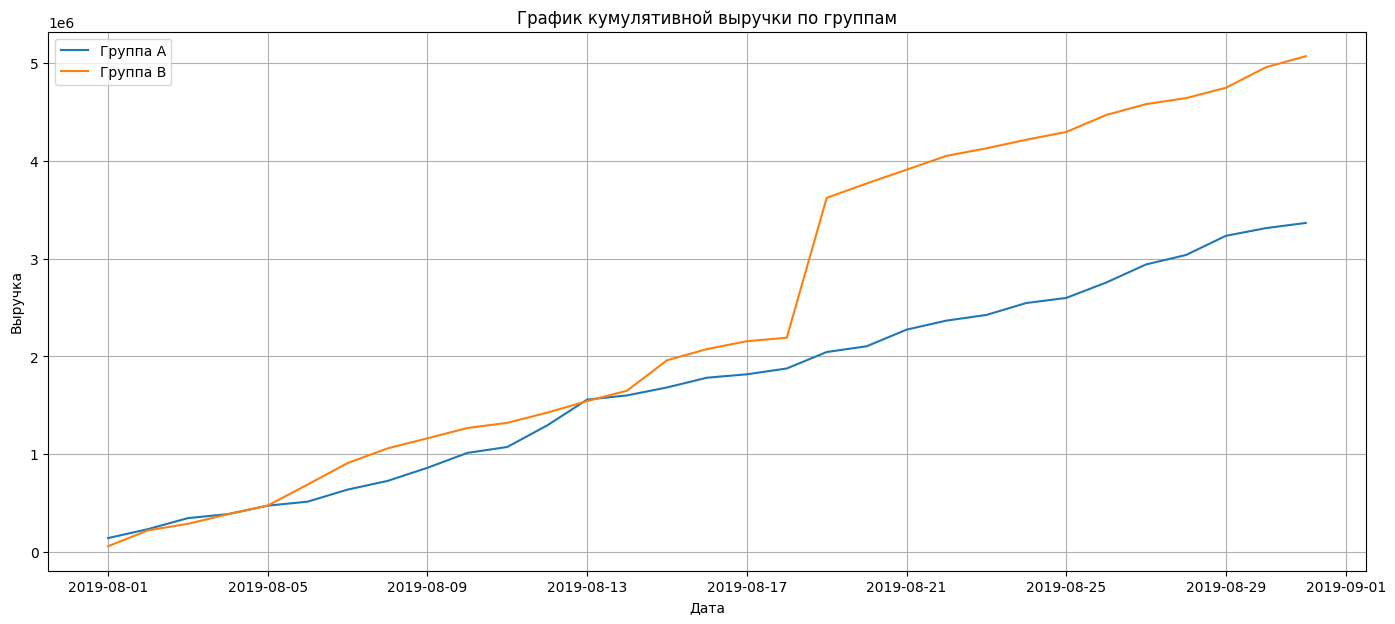

In [54]:
plt.figure(figsize=(17, 7))

# строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='Группа A')

# строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='Группа B')

plt.title('График кумулятивной выручки по группам')
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.grid()
plt.legend();

**Итог:**
По графику мы наблюаем следующую картину:
- выручка в первой половине месяца для обеих групп равномерно одинаково растет;
- 13 августа выручка обеих групп сходится в одной точке, это может говорить о том, что по выручке заказов группы равны;
- после 13 августа `группа В` вырывается вперед, а 18 августа получает очень сильный скачок. Данный скачок может говорить о том, что могли быть совершены аномально дорогие заказы. Если данный заказ(ы) отбросить, то можно наблюдать равномерно одинаковый рост выручки для обеих групп.

### Кумулятивный средний чек по группам

***
**ЗАДАЧА.** Построить график кумулятивного среднего чека по группам. Сделать выводы и предположения.
***

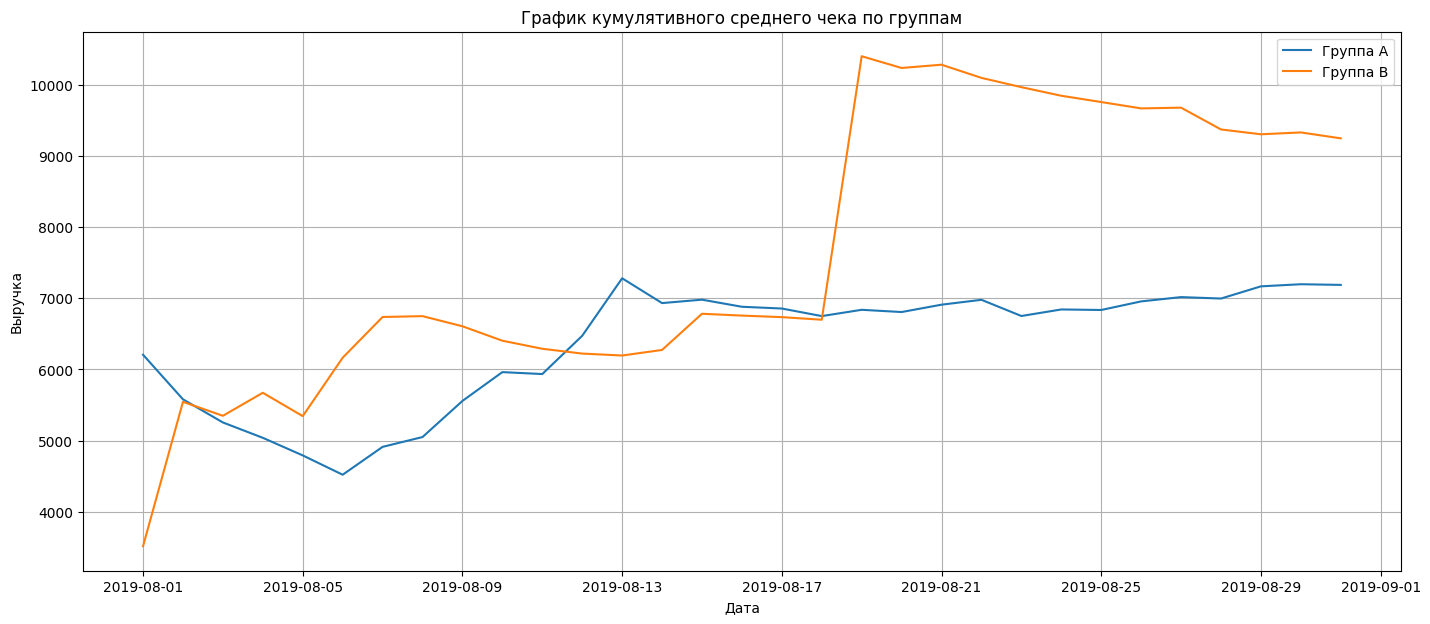

In [55]:
plt.figure(figsize=(17, 7))
# строим график среднего чека группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='Группа A')
# строим график среднего чека группы В
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='Группа B')

plt.title('График кумулятивного среднего чека по группам')
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.grid()
plt.legend();

**Итог:** По графику мы наблюаем следующую картину:
- в первой половине месяца происходят постоянные колебания по обеим группам;
- преимущественно в первой половине месяца средний чек больше в `группе В`;
- как и на графике кумулятивной выручки мы наблюдаем всплеск среднего чека у группы 18 августа, что может быть также является причиной аномальных заказов;
- после аномальног всплеска наблюдается плавный спад среднего чека `группы В`, с явным приближением по значениям к `группе В`;
- средний чек `группы А` на протяжении всей второй половины месяца плавно растет;
- необходимо выполнить анализ аномальных выбросов.

### Относительные изменения кумулятивного среднего чека группы B к группе A

***
**ЗАДАЧА.** Построить график относительного изменения кумулятивного среднего чека группы B к группе A. Сделать выводы и предположения.
***

In [56]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = \
cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

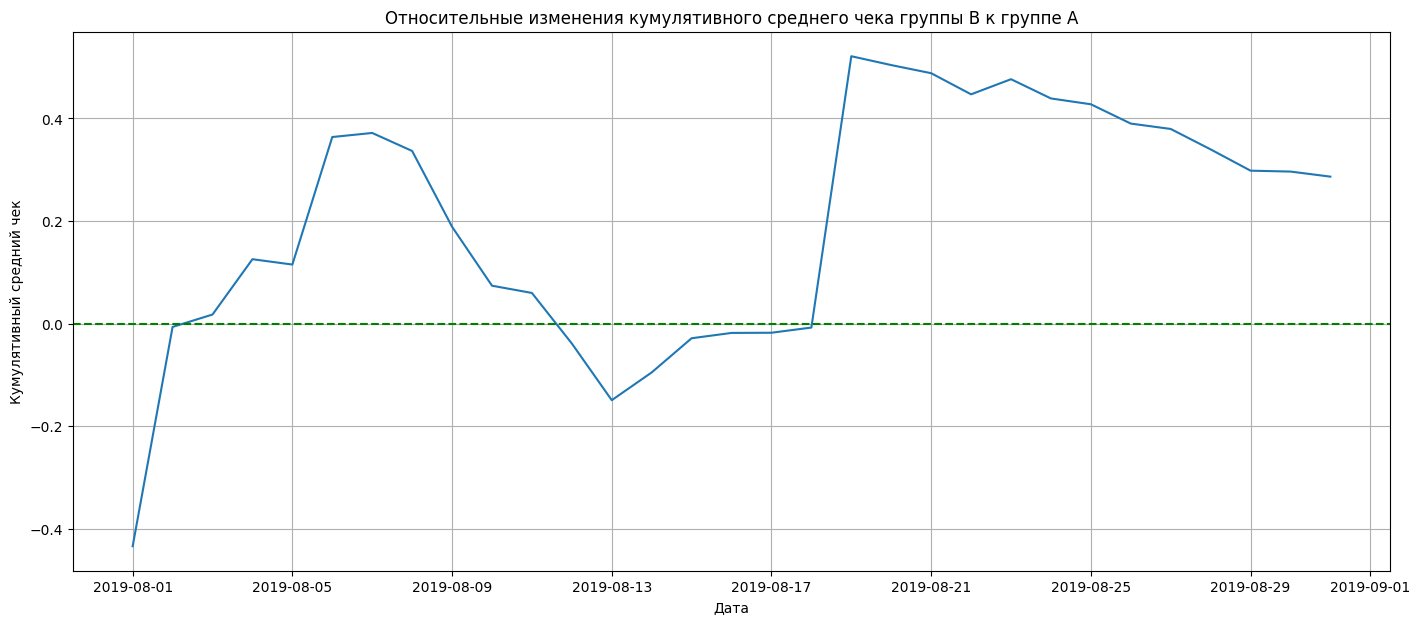

In [57]:
plt.figure(figsize=(17,7))

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'],(mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='green', linestyle='--')

plt.grid()
plt.xlabel('Дата')
plt.ylabel('Кумулятивный средний чек')
plt.title('Относительные изменения кумулятивного среднего чека группы B к группе A');

**Итог:** По полученным данным на графике мы наблюдаем аналогичную картину, что и при изучении относительного изменения кумулятивного среднего чека:

- средний чек `группы В` рос с 1 августа до 7 августа, значение `группы А` превысил 2 августа;
- после 7 августа рост среднего чека `группы В` пошел на спад до 13 августа и 12-14 август средний чек `группы А` был выше;
- с 13 августа средний чек `группы В` начал вновь расти и 18 августа произошел резкий всплеск, что снова может может говорить об аномальных заказах;
- после 18 августа средний чек `группы В` также продолжал быть выше среднего чека `группы А`, но с плавным спадом и выравниванием.

### Комулятивное среднее количество заказов на посетителя по группам

***
**ЗАДАЧА.** Построить график кумулятивного среднего количества заказов на посетителя по группам. Сделать выводы и предположения.
***

In [58]:
# считаем кумулятивное среднее количество заказов на посетителя
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

In [59]:
# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

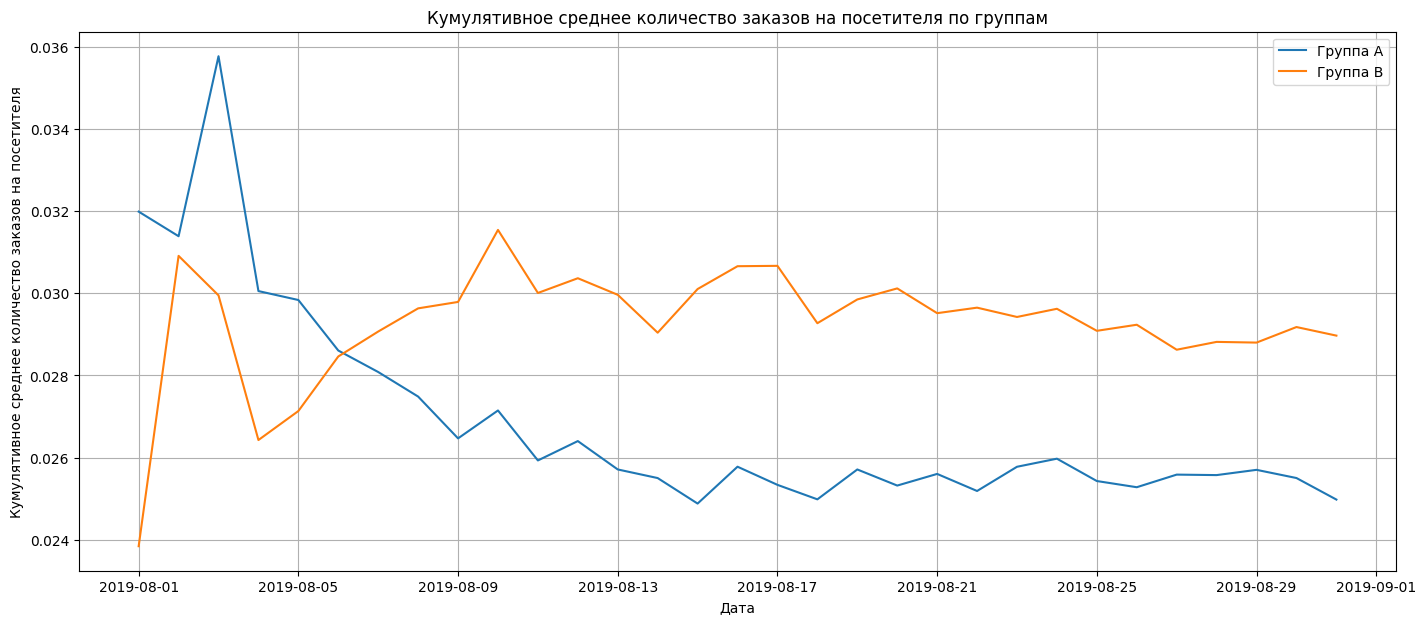

In [60]:
plt.figure(figsize=(17,7))

# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='Группа A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='Группа B')

plt.grid()
plt.xlabel('Дата')
plt.ylabel('Кумулятивное среднее количество заказов на посетителя')
plt.title('Кумулятивное среднее количество заказов на посетителя по группам')
plt.legend();

**Итог:** По полученному графику можно сделать следующие выводы:

- на начальном этапе теста среднее количество заказов на посетителя `группы А` значительно выше, чем у `группы В`;
- 3 августа среднее количество заказов на посетителя `группы А` была на максимальном пике (~ 0.036), после чего пошло на спад;
- в период с 4 августа среднее количество заказов на посетителя `группы В` начало расти в уверенным темпом, данный рост уже 6 августа превысил среднее количество заказов на посетителя `группы А`, стабильный рост продолжался до 10 августа;
- начиная с 6 августа среднее количество заказов на посетителя `группы В` до конца месяца стабильно держалась выше среднего количества заказов на посетителя `группы А`.

Основным выводом можно сделать, что среднее количество заказов на посетителя `группы В` значительно выше среднего количества заказов на посетителя `группы А`.

### Относительные изменения кумулятивного среднего количества заказов на посетителя группы B к группе A по группам

***
**ЗАДАЧА.** Построить график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A. Сделать выводы и предположения.
***

In [61]:
# собираем данные в одном датафрейме
mergedCumulativeConversions = \
cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], \
                                             left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

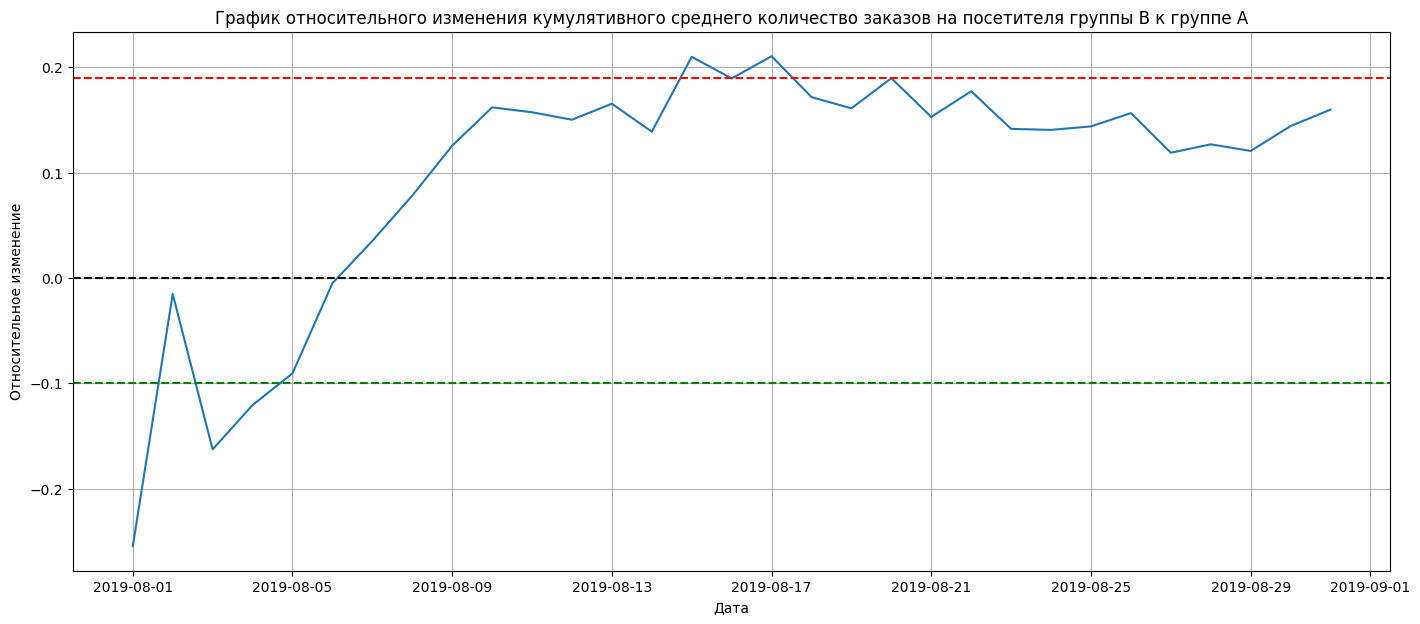

In [62]:
plt.figure(figsize=(17,7))

# cтроим отношение средних количество
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.grid()
plt.xlabel('Дата')
plt.ylabel('Относительное изменение')
plt.title('График относительного изменения кумулятивного среднего количество заказов на посетителя группы B к группе A')

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='green', linestyle='--')
plt.axhline(y=0.19, color='red', linestyle='--');

**Итог:** По полученному графику можно сделать следующие выводы:

- с 1 по 5 августа кумулятивное среднее количество заказов на посетителя `группы А` держится больше кумулятивного среднего количества заказов на посетителя `группы В` на 5-10%, кроме 2 августа - среднее кол-во заказов на посетителя `группы В` взяла лидерство на 5% больше чем у `группы А`;
- с 6 августа наблюдается стабильный сильный рост среднего кол-ва заказов на посетителя `группы В`, который продолжается до 15 августа и достигает рекордного процента - 21;
- после 15 августа среднее кол-во заказов на посетителя `группы В` стабильно была выше и находилась на уровне от 10 до 15%.

### Точечный график количества заказов по пользователям

***
**ЗАДАЧА.** Построить точечный график количества заказов по пользователям. Сделать выводы и предположения.
***

In [63]:
# создадим датафрейм c двумя столбцами 'transaction_id' и 'orders'
ordersByUsers = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
    .rename(columns={'transaction_id' : 'orders'})
)

In [64]:
# отсортируем по убыванию количества заказов пользователей и выведим на экран первые 10 строк
ordersByUsers.sort_values(by='orders', ascending=False).head(10)

,visitor_id,orders
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3
138,611059232,3
632,2742574263,3
157,678354126,2
323,1404560065,2
452,1985475298,2


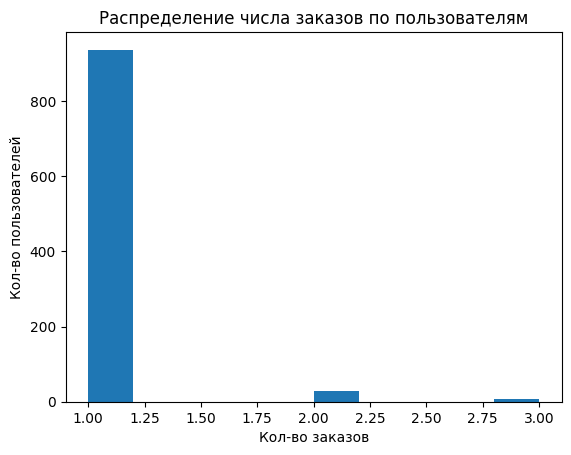

In [65]:
# построим гистограмму распределения числа заказов по пользователям
plt.hist(ordersByUsers['orders'])
plt.ylabel('Кол-во пользователей')
plt.xlabel('Кол-во заказов')
plt.title('Распределение числа заказов по пользователям');

Большинство совершало 1 заказ, но также имеются пользователи, которые совершают от 2х до 4х заказов. Также на графике наблюдаются пользователи, которые сделали больше 10 заказов. Для более конкретного понимания построим точечный график.

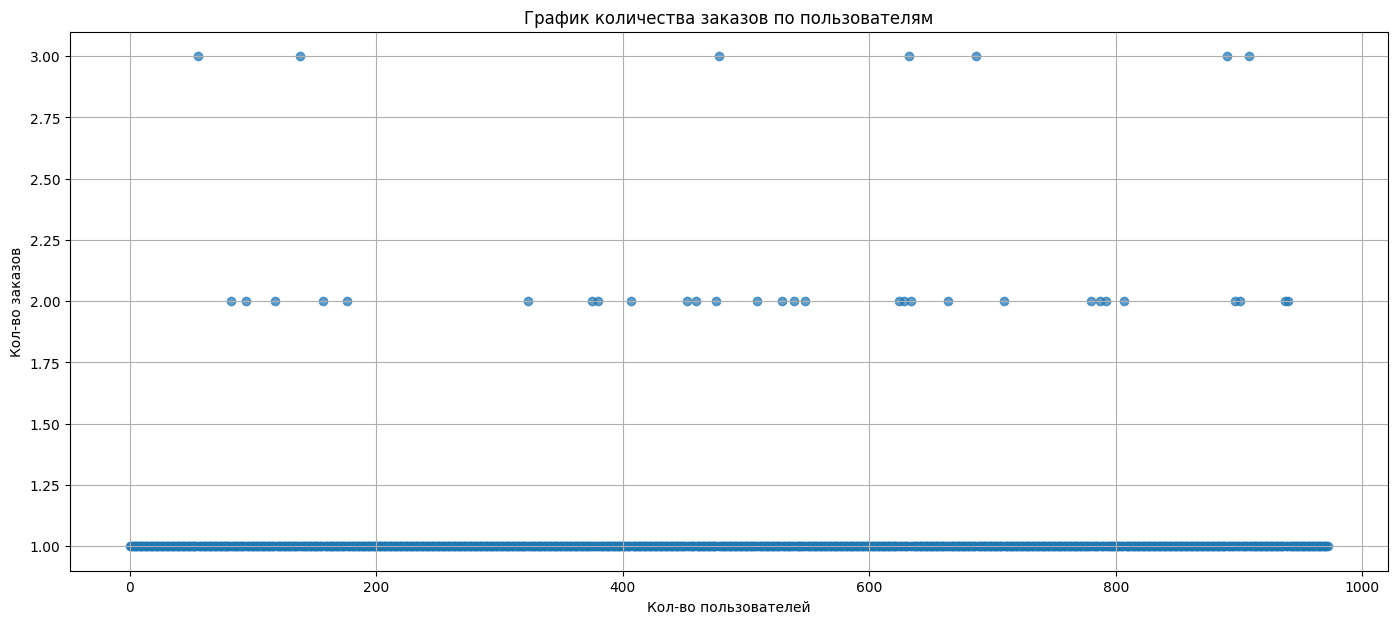

In [66]:
x_values = pd.Series(range(0, len(ordersByUsers)))

plt.figure(figsize=(17,7))
plt.grid()
plt.xlabel('Кол-во пользователей')
plt.ylabel('Кол-во заказов')
plt.title('График количества заказов по пользователям')
plt.scatter(x_values, ordersByUsers['orders'], alpha=0.7);

**Итог:** По полученному графику можно сделать следующие выводы:
- наибольшее количество пользователей делает 1 заказ;
- пользователей, делающих 2 заказа, также много, но все же 2 заказа делают значительно реже;
- 3 заказа делают еще реже, на данный момент еще не ясно является ли это аномалией.

На данный момент можно зафиксировать, что более 3х заказов является аномалией. Необходимо посчитать перцентили: 95 и 99.

### Границы для определение аномальных пользователей

***
**ЗАДАЧА.** Посчитать 95-й и 99-й перцентили количества заказов на пользователя. Выберать границу для определения аномальных пользователей.
***

In [67]:
# посчитаем перцентили
print('95-й перцентиль по заказам : ', np.percentile(ordersByUsers['orders'], [95]))
print('99-й перцентиль по заказам : ', np.percentile(ordersByUsers['orders'], [99]))

95-й перцентиль по заказам :  [1.]
99-й перцентиль по заказам :  [2.]


По 99-му перцентилю наблюдаем, что не больше 1% пользователей выполняют больше 2х заказов. Для более полной картины и понимания посчитаем 96-98 перцентили

In [68]:
print('95 - 99 перцентили по заказам : ',np.percentile(ordersByUsers['orders'], [95, 96, 97, 98, 99]))

95 - 99 перцентили по заказам :  [1. 1. 2. 2. 2.]


**Итог:** Совершение пользователями больше 2-х заказов предлагаю считать аномальным, так как 98% пользователей совершает не больше 2х заказов.

### Точечный график стоимостей заказов

***
**ЗАДАЧА.** Построить точечный график стоимостей заказов. Сделать выводы и предположения.
***

In [69]:
# выведим таблицу заказов и отсортируем по выручке на убывание
orders.sort_values(by='revenue', ascending=False).head(10)

,transaction_id,visitor_id,date,revenue,group
425,590470918,1920142716,2019-08-19,1294500,B
1196,3936777065,2108080724,2019-08-15,202740,B
1136,666610489,1307669133,2019-08-13,92550,A
744,3668308183,888512513,2019-08-27,86620,B
743,3603576309,4133034833,2019-08-09,67990,A
1103,1348774318,1164614297,2019-08-12,66350,A
1099,316924019,148427295,2019-08-12,65710,A
949,1347999392,887908475,2019-08-21,60450,A
940,2420050534,4003628586,2019-08-08,58550,B
131,3163614039,2254586615,2019-08-22,53904,A


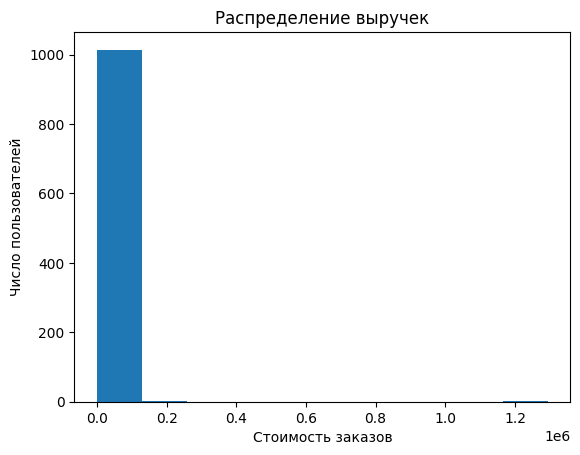

In [70]:
# построим гистограмму распределения выручек
plt.hist(orders['revenue'])
plt.ylabel('Число пользователей')
plt.xlabel('Стоимость заказов')
plt.title('Распределение выручек');

Наибольше количество заказов приносит выручку меньше 200 000. Для более конкретного понимания построим точечный график.

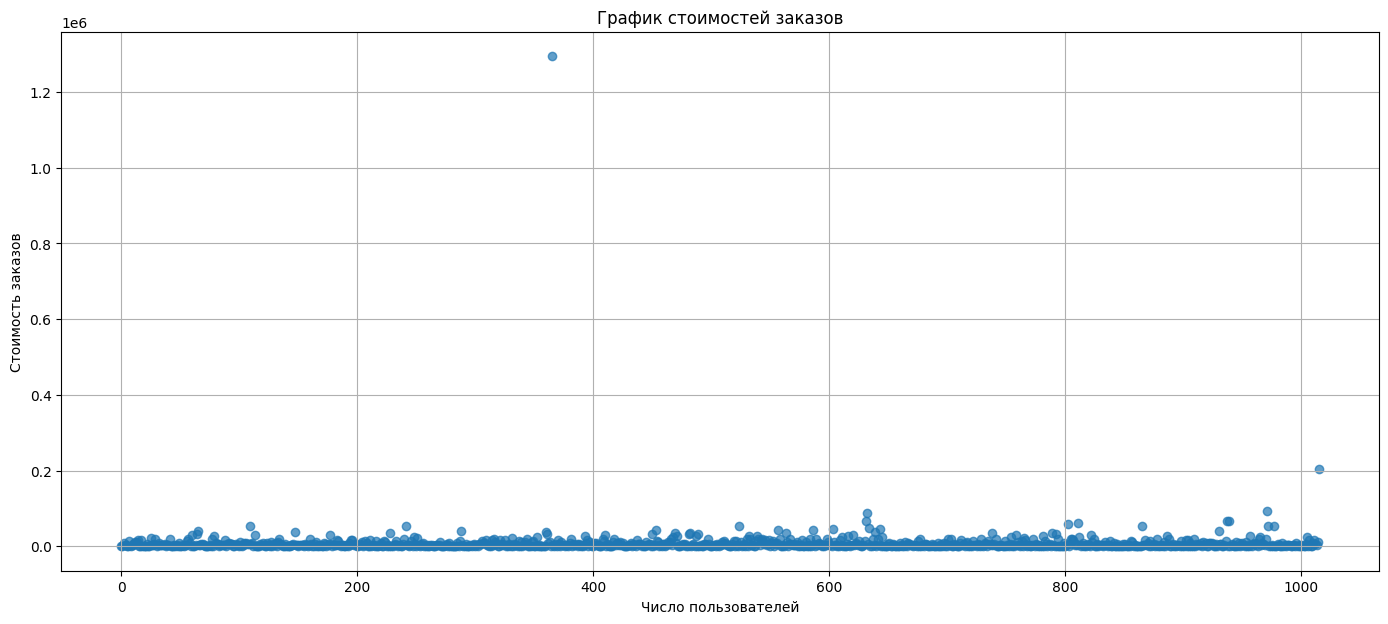

In [71]:
x_values = pd.Series(range(0, len(orders['revenue'])))

plt.figure(figsize=(17,7))
plt.grid()
plt.title('График стоимостей заказов')
plt.xlabel('Число пользователей')
plt.ylabel('Стоимость заказов')
plt.scatter(x_values, orders['revenue'], alpha=0.7);

На полученном графике наблюдаев выброс, который более 1.2 млн. Уменьшим диапазон вывода данных для получения более конкретной картины. Границей примем значение 201 000.

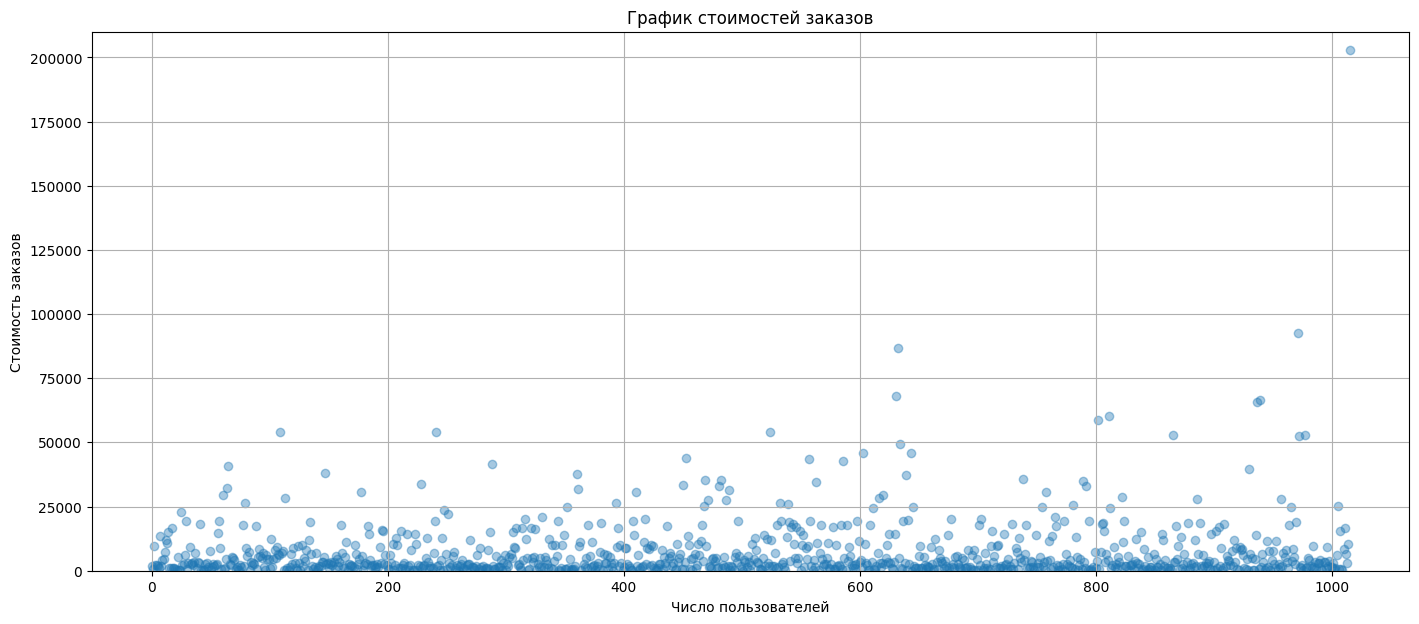

In [72]:
plt.figure(figsize=(17,7))
plt.grid()
plt.title('График стоимостей заказов')
plt.xlabel('Число пользователей')
plt.ylabel('Стоимость заказов')
plt.scatter(x_values, orders['revenue'], alpha=0.4)
plt.ylim(0, 210000);

**Итог:** По полученным графикам можно сделать следующие выводы:
- на первом графике наблюдается один аномальный заказ на ~ 1,2 млн;
- на усеченном графике наблюдается один выброс чуть больше 200 000;
- большая часть заказов не превышает стоимость в 100 000.

Для более точного определения границ необходимо посчитать перцентили: 95 и 99.

### Границы для определения аномальных заказов

***
**ЗАДАЧА.** Посчитать 95-й и 99-й перцентили стоимости заказов. Выбрать границу для определения аномальных заказов.
***

In [73]:
# посчитаем перцентили
print('95-й перцентиль по заказам : ', np.percentile(orders['revenue'], [95]))
print('99-й перцентиль по заказам : ', np.percentile(orders['revenue'], [99]))

95-й перцентиль по заказам :  [26785.]
99-й перцентиль по заказам :  [53904.]


**Итог:** 99% совершенных заказов пользователями не превышает 53904. Как граница для фильтра аномалий примем значение в 54000.

### Cтатистическая значимость различий в в среднем количестве заказов на посетителя между группами по «сырым» данным

***
**ЗАДАЧА.** Посчитать статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным. Сделать выводы и предположения.
***

Перед решением поставленной задачи обозначим гипотезы:\
<b>Нулевая</b>: cтатистической значимости различий в среднем количестве заказов на посетителя между группами нет.\
<b>Альтернативная</b>: cтатистическая значимость различия в среднем количестве заказов на посетителя между группами есть.

Применим критерием Манна-Уитни, так как в данных есть большие (по сравнению с нормальным распределением) выбросы. Порогом статистической значимости установим alpha = 0.05

In [74]:
# подготовим все данные по заказам и визитам
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

In [75]:
# соберем подготовленные в одну таблицу
cummulative = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

In [76]:
# выведем полученную таблицу
cummulative.head(5)

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,719,713,719,713
1,2019-08-02,19,91602,23,162043,42,234381,40,221801,619,581,1338,1294
2,2019-08-03,24,112473,14,67049,66,346854,54,288850,507,509,1845,1803
3,2019-08-04,11,41176,14,96890,77,388030,68,385740,717,770,2562,2573
4,2019-08-05,22,86383,21,89908,99,474413,89,475648,756,707,3318,3280


In [77]:
# cоздадим переменные для пользователей, которые заказывали хотя бы один раз
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']

In [78]:
# создадим переменные, в которых пользователям из разных групп будет соответствовать количество заказов
sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                cummulative['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                cummulative['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

In [79]:
print("alpha =",0.05)

print("p-value =", "{0:.5f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print("Относительные показатели групп:", "{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

alpha = 0.05
p-value = 0.01102
Относительные показатели групп: 0.160


**Итог:** По полученным данным наблюдаем, что p-value значительно меньше 0.05.

Следовательно мы отвергаем нулевую гипотезу и также фиксируем, что статистическая значимость различий в среднем количестве заказов на посетителя между `группами А` и `В` по «сырым» данным есть. Относительный прирост среднего `группы В` к среднему `группы А` равен 13,8%.

### Cтатистическая значимость различий в среднем чеке заказа между группами по «сырым» данным

***
**ЗАДАЧА.** Посчитать статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделать выводы и предположения.
***

Перед решением поставленной задачи обозначим гипотезы:\
<b>Нулевая</b>: cтатистической значимости различий в среднем чеке между группами нет.\
<b>Альтернативная</b>: cтатистическая значимость различия в среднем чеке между группами есть.

In [80]:
print("p-value =", '{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'],\
                                          orders[orders['group']=='B']['revenue'])[1]))
print("Относительные показатели групп:", \
      '{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

p-value = 0.829
Относительные показатели групп: 0.287


**Итог:** По полученным данным наблюдаем, что p-value значительно больше 0.05.

Следовательно мы не можем отвергнуть нулевую гипотезу, из чего делаем вывод, что статистической значимости различий в среднем чеке заказа между `группами А` и `В` по «сырым» данным нет. При этом средний чек `группы В` превышает средний чек `группы A` больше чем на 25%.

### Cтатистическая значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным

***
**ЗАДАЧА.** Посчитать статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным. Сделать выводы и предположения.
***

Ранее в данном проекте мы определили следующих аномальных пользователей:
- те кто сделал 3 и больше заказов;
- те кто совершил заказ больше чем на 53904.

Сделаем два среза, чтобы определить количество аномальных пользователей:
- с пользователями которые сделали больше 2х заказов;
- с пользователями которые оформили заказк больше чем 54000.

In [81]:
# срез пользователей с числом заказов больше 2
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['userId'],
    ],
    axis=0,
)

# срез пользователей c заказом больше чем на 54000
usersWithExpensiveOrders = orders[orders['revenue'] > 54000]['visitor_id']

In [82]:
# объединим срезы в таблице и посчитаем количество аномальных пользователей
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))
print('Количество аномальных пользователей: ', abnormalUsers.shape[0])

1099    148427295
33      249864742
58      611059232
949     887908475
744     888512513
dtype: int64
Количество аномальных пользователей:  16


In [83]:
# посчитаем относительные потери
print('Относительные потери:', round(abnormalUsers.shape[0] / orders['visitor_id'].nunique() * 100, 2), '%')

Относительные потери: 1.64 %


Необходимо посмотреть как данные пользователи повлияли на результаты теста. Подготовим выборки количества заказов по пользователям по группам теста

In [84]:
# подготовим выборки количества заказов по пользователям по группам теста
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                cummulative['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                cummulative['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

Перед решением поставленной задачи обозначим гипотезы:\
<b>Нулевая</b>: cтатистической значимости различий в среднем количестве заказов на посетителя между группами нет.\
<b>Альтернативная</b>: cтатистическая значимость различия в среднем количестве заказов на посетителя между группами есть.

In [85]:
print("p-value =", '{0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print("Относительные показатели групп:", '{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

p-value = 0.007
Относительные показатели групп: 0.189


**Итог.** По полученным данным наблюдаем, что p-value значительно меньше 0.05.

Следовательно мы отвергаем нулевую гипотезу и также фиксируем, что статистическая значимость различий в среднем количестве заказов на посетителя между `группами А` и `В` по «очищенным» данным есть, также как и по "сырым" данным. Относительный прирост среднего `группы В` к среднему `группы А` равен 17,4%, что на 4,3% больше, чем по "сырым" данным (13,8%).

### Cтатистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным

***
**ЗАДАЧА.** Посчитать статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделать выводы и предположения.
***

Перед решением поставленной задачи обозначим гипотезы:\
<b>Нулевая</b>: cтатистической значимости различий в среднем чеке между группами нет.\
<b>Альтернативная</b>: cтатистическая значимость различия в среднем чеке между группами есть.

In [86]:
print("p-value =",\
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print("Относительные показатели групп:",\
    '{0:.3f}'.format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

p-value = 0.788
Относительные показатели групп: -0.032


**Итог:** По полученным данным наблюдаем, что p-value значительно больше 0.05.

Следовательно мы не можем отвергнуть нулевую гипотезу, из чего делаем вывод, что статистической значимости различий в среднем чеке заказа между `группами А` и `В` по «очищенным» данным нет, также как и по "сырым" данным. При этом средний чек `группы В` на 2% ниже среднего чека `группы A`, по "сырым" данным средний чек `группы В` больше чем на 25%, это было связано с аномальным заказом в ~1,2 млн, который был обозначен по пункту 2.9.

## Решение по результатам теста

***
**ЗАДАЧА.** Принять решение по результатам теста и объяснить его. Варианты решений:
1. Остановить тест, зафиксировать победу одной из групп.
2. Остановить тест, зафиксировать отсутствие различий между группами.
3. Продолжить тест.
***

<b>Предлагается остановить тест и признать победу за `группой В`, так как:</b>
- Различия в среднем количестве заказов на посетителя между `группами А` и `В` наблюдается и по "сырым", и по "очищенным" данным. Относительный прирост среднего `группы В` к среднему `группы А` равен 17,4% по "очищенным" данным и 13,8% по "сырым данным".
- Между `группами А` и `В` по результатам теста различий в средних чеках нет. Хотя по "сырым" данным средний чек `группы В` превышел средний чек `группы А` больше чем на 25% из-за возникшего аномального заказ в ~1.2 млн. По "очищенным" данным такой разницы не наблюдается и средний чек `группы В` ниже среднего чего `группы А` на 2%.